In [128]:
#s0 libs

using Combinatorics
using DelimitedFiles
using Plots
using StatsBase
using Test

#=
intent
take an array of durations of seclusion
count the actua distribution of durations
see this curve as being a probability mass function based on four other curves
over        an even Poisson
under       an odd Poisson
between     a recurring paraboloid curve which handles the gap between them
     - rescale the gap as a series of trapezoids
     - area of a parabold inside a trapezoid is 2/3 the trapezoid and width is fixed
leftover    an error function with its own polynomial mechanics


=#

#s1 config

function get_even_labda()
    labda::Int64    = 8
    return labda
end

function get_limit()
    limit           = 2
    return limit
end

function get_odd_labda()
    labda::Int64    = 12
    return labda
end

function get_width_of_hists()
    width_of_hists  = 5
    return width_of_hists
end

#s2 in out read draw

function draw_cont_scat_freqs(limited)
    count_durs      = collect(countmap(limited))
    durs            = [x[1] for x in count_durs]
    freqs           = [x[2] for x in count_durs]
    cont_scat_freqs = scatter(durs, freqs, alpha=0.25, title="durations", legend=false)
    return cont_scat_freqs
end

function draw_hist_freqs(limited)
    limit           = get_limit()
    minutes         = limit*24*60
    width_of_hists  = get_width_of_hists()
    n_hists::Int    = minutes/width_of_hists
    println("In the bar chart each bar covers:\t", width_of_hists, " minute(s)")
    println("...so there are:\t\t\t", n_hists, " slices in graphs")
    hist_freqs      = histogram(limited, bins=n_hists, alpha=0.5, legend=false, title="durations")
    return hist_freqs
end

function draw_scat_abs(limited)
    orders          = 1:length(limited)
    scat_abs        = scatter(orders, limited, alpha=0.02, title="ordered length", legend=false)
    return scat_abs
end

function draw_scat_logs(limited)
    orders          = 1:length(limited)
    log_abs         = [log2(d) for d in limited]
    scat_logs       = scatter(orders, log_abs, alpha=0.1, title="log length by order", legend=false)
    return scat_logs
end

function read_durations()
    output_matrix = readdlm("durations.txt", ' ', Float64, '\n')
    durations     = output_matrix[1,:]
    return durations
end


#s3 model

function count_limited()
    durations           = read_durations()
    total               = length(durations)
    limit               = get_limit()
    limited             = [d for d in durations if d<=limit]
    cumulative_fraction = length(limited)/total
    println("only looking at first:\t\t\t",limit," days")
    println("proportion out by then is about:\t", trunc(Int64,cumulative_fraction*100),"%")
    return limited
end

function get_xs()
    limit           = get_limit()
    minutes         = limit*24*60
    width_of_hists  = get_width_of_hists()
    n_hists::Int    = minutes/width_of_hists
    xs              = [float(x) for x in collect(1:n_hists)]
    return xs
end

function harry_maths()
    xs                  = get_xs()
    even_labda          = get_even_labda()
    even_scale          = 1000
    unscaled_even_ys    = dist_poisson(xs, even_labda)
    even_ys             = .*(unscaled_even_ys, even_scale)
    
    odd_labda           = get_odd_labda()
    odd_scale           = 1000
    unscaled_odd_ys     = dist_poisson(xs, odd_labda)
    odd_ys              = .*(unscaled_odd_ys, odd_scale)
    
    max_x               = maximum(xs)
    c                   = 50
    straight_line       = [c-(c*(x/max_x)) for x in xs]
    println(straight_line)
    
    ys                  = .+(even_ys, odd_ys, straight_line) 
    summed_poisson      = scatter(xs,ys)
    return summed_poisson
end

function initial_analysis()
    limited         = count_limited()
    scat_logs       = draw_scat_logs(limited)
    scat_abs        = draw_scat_abs(limited)
    initial         = plot(scat_abs, scat_logs, layout=(1,2), legend=false)
    return initial
end

function my_poisson(k::Int64, labda::Int64)
    
    probability = (labda^k)*(ℯ^(-labda))/factorial(big(k))
    return probability
end

function no_real_analysis()
    limited         = count_limited()
    cont_scat_freqs = draw_cont_scat_freqs(limited)
    hist_freqs      = draw_hist_freqs(limited)
    unanalysed      = plot(cont_scat_freqs, hist_freqs, layout=(1,2), legend=false)
    return unanalysed
end

function dist_poisson(xs, labda)
    xs              = [trunc(Int64,x) for x in xs]
    ys              = [my_poisson(x, labda) for x in xs]
    return ys
end




dist_poisson (generic function with 1 method)

In [129]:
function harry_main()
    unanalysed      = no_real_analysis()
    initial         = initial_analysis()
    harry_graph     = harry_maths()
    return unanalysed, initial, harry_graph
end

unanalysed, initial, harry_graph = harry_main();
    

only looking at first:			2 days
proportion out by then is about:	82%
In the bar chart each bar covers:	5 minute(s)
...so there are:			576 slices in graphs
only looking at first:			2 days
proportion out by then is about:	82%


[49.91319444444444, 49.826388888888886, 49.739583333333336, 49.65277777777778, 49.56597222222222, 49.479166666666664, 49.392361111111114, 49.30555555555556, 49.21875, 49.13194444444444, 49.045138888888886, 48.958333333333336, 48.87152777777778, 48.78472222222222, 48.697916666666664, 48.611111111111114, 48.52430555555556, 48.4375, 48.35069444444444, 48.263888888888886, 48.177083333333336, 48.09027777777778, 48.00347222222222, 47.916666666666664, 47.829861111111114, 47.74305555555556, 47.65625, 47.56944444444444, 47.482638888888886, 47.395833333333336, 47.30902777777778, 47.22222222222222, 47.135416666666664, 47.048611111111114, 46.96180555555556, 46.875, 46.78819444444444, 46.701388888888886, 46.614583333333336, 46.52777777777778, 46.44097222222222, 46.354166666666664, 46.267361111111114, 46.18055555555556, 46.09375, 46.00694444444444, 45.920138888888886, 45.833333333333336, 45.74652777777778, 45.65972222222222, 45.572916666666664, 45.486111111111114, 45.39930555555556, 45.3125, 45.2256

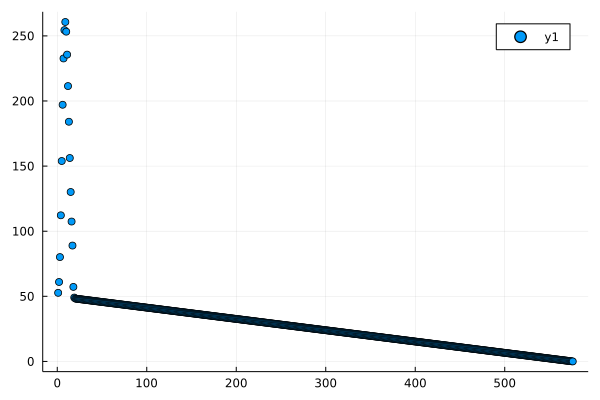

In [130]:
harry_graph

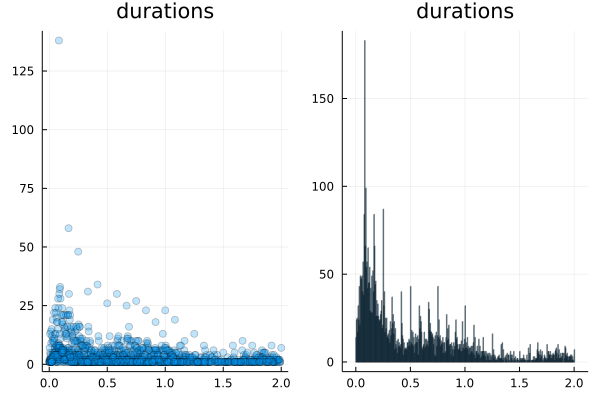

In [131]:
unanalysed

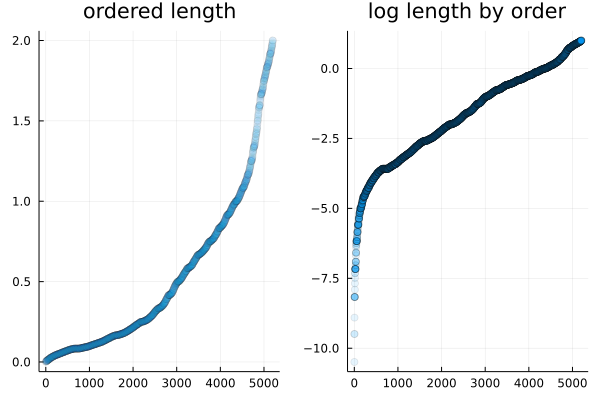

In [132]:
initial

In [133]:
#s7 tests

function test_get_xs()
    xs              = get_xs()
    limit           = get_limit()
    minutes         = limit*24*60
    width_of_hists  = get_width_of_hists()
    n_hists::Int    = minutes/width_of_hists
    @test length(xs) == n_hists
    println("passed get_xs")
end

function test_operate_on()
    xs = get_xs()
    ys = operate_on(xs)
    @test typeof(ys) == Vector{BigFloat}
    println("passed type testing for operate_on")
end

function harry_tests()
    test_get_xs()
    test_operate_on()
    println("passed all tests")
end

harry_tests()

passed get_xs
passed type testing for operate_on
passed all tests
